Disclaimer: Kindly be aware that the questions and datasets featured in this tutorial were originally presented by [Ryan Abernathy in "An Introduction to Earth and Environmental Data Science"](https://earth-env-data-science.github.io/intro.html).

# Xarray Fundamentals with Atmospheric Radiation Data

This tutorial will introduce you to the Python library, `Xarray`. Xarray is a library designed for working with multi-dimensional arrays. This allows for the handling of geoscience data which typically involve multiple dimensions - for instance, latitude, longitude, time, and channels *(Python Basics 5: Xarray — Digital Earth Africa Training 0.1 Documentation, n.d.)*. Xarray has two basic data types

- `xarray.DataArray` - an array of data as well as its meta data
  <p>For example an array of temperatures across the surface of the earth.
- `xarray.Dataset` - multiple data arrays merged into a single dataset with all associated metadata.
  <p>For example temperature and precipitation data across the surface of the earth.

Xarray is primary used to work with NetCDF files.

By the end of this tutorial, you would ahve gained a basic understanding of data manipulation and visualisation using Xarray.

<img src="https://docs.xarray.dev/en/stable/_images/dataset-diagram.png" width=65%>
<br>
<br>
<br>
<br>

We will use Xarray to analyze top-of-atmosphere radiation data from [NASA's CERES project](https://ceres.larc.nasa.gov/).

<img src="https://upload.wikimedia.org/wikipedia/commons/b/bb/The-NASA-Earth%27s-Energy-Budget-Poster-Radiant-Energy-System-satellite-infrared-radiation-fluxes.jpg" width=40%>

_Public domain, by NASA, from Wikimedia Commons_


A pre-downloaded and subsetted a portion of the CERES dataset is available here: http://ldeo.columbia.edu/~rpa/CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc. The size of the data file is 702.53 MB. It may take a few minutes to download.

Please review the CERES [FAQs](https://ceres.larc.nasa.gov/resources/faqs) before getting started.

Start by importing Numpy, Matplotlib, and Xarray. Set the default figure size to (12, 6).

In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = (12, 6)
%config InlineBackend.figure_format = 'retina'

#filter warnings for cleaner notebook look
import warnings
warnings.filterwarnings('ignore')

Next, let's download the NetCDF file.

### Checking and changing working directory

In [2]:
!pwd

/notebook_dir/mypublic/Tutorial/Chapters/3_pandas_xarray


In [3]:
%cd /notebook_dir/mypublic/Tutorial/Chapters/

/notebook_dir/mypublic/Tutorial/Chapters


In [4]:
!pwd

/notebook_dir/mypublic/Tutorial/Chapters


<br>
<br>

### Fetching the data

In [5]:
import requests

data_url = "http://ldeo.columbia.edu/~rpa/CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc"

response = requests.get(data_url, verify=False)

with open("CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc", mode="wb") as file:
   file.write(response.content)

#### Code Explanation

While `pooch` is a robust tool for retrieving data from remote sources, it does have limitations, particularly when facing issues such as errors in the URL hosting the dataset. In such cases, `pooch` might raise exceptions, necessitating an alternative approach.

To illustrate this, we define the URL of the data source and utilize the `requests` library to retrieve the data, setting SSL verification to False for cases where secure socket layer verification poses challenges.
```python
data_url = "http://ldeo.columbia.edu/~rpa/CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc"

response = requests.get(data_url, verify=False)
```

Subsequently, we save the file contents to a specified directory.
```python
with open("CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc", mode="wb") as file:
   file.write(response.content)
```
The data is now available with the specified name within the `open()` function.

To further illustrate this limitation, run the code below and compare the output to that using the alternative method.
```python
import pooch
fname = pooch.retrieve(
    'http://ldeo.columbia.edu/~rpa/CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc',
    known_hash='a876cc7106e7dcb1344fbec5dcd7510e5cd947e62049a8cbc188ad05ffe00345', 
    progressbar=True
)
print(fname)
```
<br>
<br>
<br>

## 1) Opening data and examining metadata

### 1.1) Open the dataset and display its contents 


copy name from directory

In [6]:
#create a variable to store file name
data_file = "CERES_EBAF-TOA_Edition4.0_200003-201701.condensed.nc"

#open data using x_array
data = xr.open_dataset(data_file)
data

<xarray.Dataset>
Dimensions:                      (lon: 360, time: 203, lat: 180)
Coordinates:
  * lon                          (lon) float32 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * time                         (time) datetime64[ns] 2000-03-15 ... 2017-01-15
  * lat                          (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables: (12/14)
    toa_sw_all_mon               (time, lat, lon) float32 ...
    toa_lw_all_mon               (time, lat, lon) float32 ...
    toa_net_all_mon              (time, lat, lon) float32 ...
    toa_sw_clr_mon               (time, lat, lon) float32 ...
    toa_lw_clr_mon               (time, lat, lon) float32 ...
    toa_net_clr_mon              (time, lat, lon) float32 ...
    ...                           ...
    toa_cre_net_mon              (time, lat, lon) float32 ...
    solar_mon                    (time, lat, lon) float32 ...
    cldarea_total_daynight_mon   (time, lat, lon) float32 ...
    cldpress_total_daynight_mon  (time, lat, lon) float32 ...
    cldtemp_total_daynight_mon   (time, lat, lon) float32 ...
    cldtau_total_day_mon         (time, lat, lon) float32 ...
Attributes:
    title:             CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Mo...
    institution:       NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:       CF-1.4
    comment:           Data is from East to West and South to North.
    Version:           Edition 4.0; Release Date March 7, 2017
    Fill_Value:        Fill Value is -999.0
    DOI:               10.5067/TERRA+AQUA/CERES/EBAF-TOA_L3B.004.0
    Production_Files:  List of files used in creating the present Master netC...

The `open_dataset()` function is used to open NetCDF files from a specified location. Since we've set the notebook's working directory, specifying only the file name is sufficient. Note, if the file is located in a different directory, it becomes necessary to provide the full path to access it.

Let's introduce some basic `xarray` functions and attributes.

In [7]:
data.attrs

{'title': 'CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Monthly Averages and 07/2005 to 06/2015 Climatology.',
 'institution': 'NASA/LaRC (Langley Research Center) Hampton, Va',
 'Conventions': 'CF-1.4',
 'comment': 'Data is from East to West and South to North.',
 'Version': 'Edition 4.0; Release Date March 7, 2017',
 'Fill_Value': 'Fill Value is -999.0',
 'DOI': '10.5067/TERRA+AQUA/CERES/EBAF-TOA_L3B.004.0',
 'Production_Files': 'List of files used in creating the present Master netCDF file:\n/homedir/nloeb/ebaf/monthly_means/adj_fluxes/deliverable/sw*.gz\n/homedir/nloeb/ebaf/monthly_means/adj_fluxes/deliverable/lw*.gz\n/homedir/nloeb/ebaf/monthly_means/adj_fluxes/deliverable/net*.gz\n/homedir/nloeb/ebaf/monthly_means/adj_fluxes/deliverable/solflx*.gz\n/homedir/nloeb/ebaf/monthly_means/out_glob.dat'}

`attrs` is an attribute of the Dataset variable, it can be used to access the metadata stored about the dataset and its variables
<br>

In [8]:
data.coords

Coordinates:
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 2000-03-15 2000-04-15 ... 2017-01-15
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

`coords` is an attribute used to return the corrdinates assigned to each reference point. Note the variables with a `*`

In [9]:
data.indexes

Indexes:
    lon      Index([  0.5,   1.5,   2.5,   3.5,   4.5,   5.5,   6.5,   7.5,   8.5,   9.5,
       ...
       350.5, 351.5, 352.5, 353.5, 354.5, 355.5, 356.5, 357.5, 358.5, 359.5],
      dtype='float32', name='lon', length=360)
    time     DatetimeIndex(['2000-03-15', '2000-04-15', '2000-05-15', '2000-06-15',
               '2000-07-15', '2000-08-15', '2000-09-15', '2000-10-15',
               '2000-11-15', '2000-12-15',
               ...
               '2016-04-15', '2016-05-15', '2016-06-15', '2016-07-15',
               '2016-08-15', '2016-09-15', '2016-10-15', '2016-11-15',
               '2016-12-15', '2017-01-15'],
              dtype='datetime64[ns]', name='time', length=203, freq=None)
    lat      Index([-89.5, -88.5, -87.5, -86.5, -85.5, -84.5, -83.5, -82.5, -81.5, -80.5,
       ...
        80.5,  81.5,  82.5,  83.5,  84.5,  85.5,  86.5,  87.5,  88.5,  89.5],
      dtype='float32', name='lat', length=180)

Coordinates with an asterix as also the indexes of your dataset. This means we can aggregate over any of the index variables.

### 1.2) Printing the `long_name` of each variable

In `xarray`, attributes are organized in a structure similar to a dictionary. To retrieve the long name associated with each variable in the dataset, we can iterate through the variables using the following code snippet:

In [13]:
#loop through the variables
for variable in data.variables:
    #get the long name from attributes
    long_name = data[variable].attrs.get("long_name",'')
    print(f"{variable} -- {long_name}.")

lon -- longitude.
toa_sw_all_mon -- Top of The Atmosphere Shortwave Flux, Monthly Means, All-Sky conditions.
toa_lw_all_mon -- Top of The Atmosphere Longwave Flux, Monthly Means, All-Sky conditions.
toa_net_all_mon -- Top of The Atmosphere Net Flux, Monthly Means, All-Sky conditions.
toa_sw_clr_mon -- Top of The Atmosphere Shortwave Flux, Monthly Means, Clear-Sky conditions.
toa_lw_clr_mon -- Top of The Atmosphere Longwave Flux, Monthly Means, Clear-Sky conditions.
toa_net_clr_mon -- Top of The Atmosphere Net Flux, Monthly Means, Clear-Sky conditions.
toa_cre_sw_mon -- Top of The Atmosphere Cloud Radiative Effects Shortwave Flux, Monthly Means.
toa_cre_lw_mon -- Top of The Atmosphere Cloud Radiative Effects Longwave Flux, Monthly Means.
toa_cre_net_mon -- Top of The Atmosphere Cloud Radiative Effects Net Flux, Monthly Means.
solar_mon -- Incoming Solar Flux, Monthly Means.
cldarea_total_daynight_mon -- Cloud Area Fraction, Monthly Means, Daytime-and-Nighttime conditions.
cldpress_total

This loop iterates over each variable in the dataset, extracting its attributes, and specifically obtaining the value assigned to the long_name attribute. The resulting information is then printed for each variable, providing a clear understanding of their respective long names

<br>
<br>

## 2) Basic reductions, arithmetic, and plotting

### 2.1) Calculate the time-mean of the entire dataset

Similar to the functionality in pandas, in `xarray`, we can compute the mean along a specific dimension. However, unlike pandas' `axis` argument, here we use `dim` followed by the dimension's name to specify the dimension along which we want to compute the mean.

In [14]:
#taking mean along a specific dimension
time_mean = data.mean(dim='time')
time_mean

<xarray.Dataset>
Dimensions:                      (lon: 360, lat: 180)
Coordinates:
  * lon                          (lon) float32 0.5 1.5 2.5 ... 357.5 358.5 359.5
  * lat                          (lat) float32 -89.5 -88.5 -87.5 ... 88.5 89.5
Data variables: (12/14)
    toa_sw_all_mon               (lat, lon) float32 122.3 122.3 ... 104.4 104.4
    toa_lw_all_mon               (lat, lon) float32 141.1 141.1 ... 194.1 194.1
    toa_net_all_mon              (lat, lon) float32 -91.29 -91.29 ... -126.3
    toa_sw_clr_mon               (lat, lon) float32 119.9 119.9 ... 89.47 89.47
    toa_lw_clr_mon               (lat, lon) float32 140.2 140.2 ... 200.4 200.4
    toa_net_clr_mon              (lat, lon) float32 -88.03 -88.03 ... -117.6
    ...                           ...
    toa_cre_net_mon              (lat, lon) float32 -3.253 -3.251 ... -8.651
    solar_mon                    (lat, lon) float32 172.1 172.1 ... 172.3 172.3
    cldarea_total_daynight_mon   (lat, lon) float32 51.52 51.52 ... 78.93 78.93
    cldpress_total_daynight_mon  (lat, lon) float32 486.5 486.5 ... 766.9 766.9
    cldtemp_total_daynight_mon   (lat, lon) float32 225.2 225.2 ... 247.9 247.9
    cldtau_total_day_mon         (lat, lon) float32 4.158 4.158 ... 4.821 4.821

The resulting DataFrame contains only `lat` and `lon` as coordinates and indices since the time coordinate has been aggregated into a mean for each location across the time-series
<br>
<br>

### 2.2) 2D plot of the the time-mean Top of Atmosphere (TOA) Longwave, Shortwave, and Incoming Solar Radiation


One more similarity between `Xarray` and `Pandas` is their direct integration with `matplotlib` via the `plot()` function, enabling seamless visualization of data.

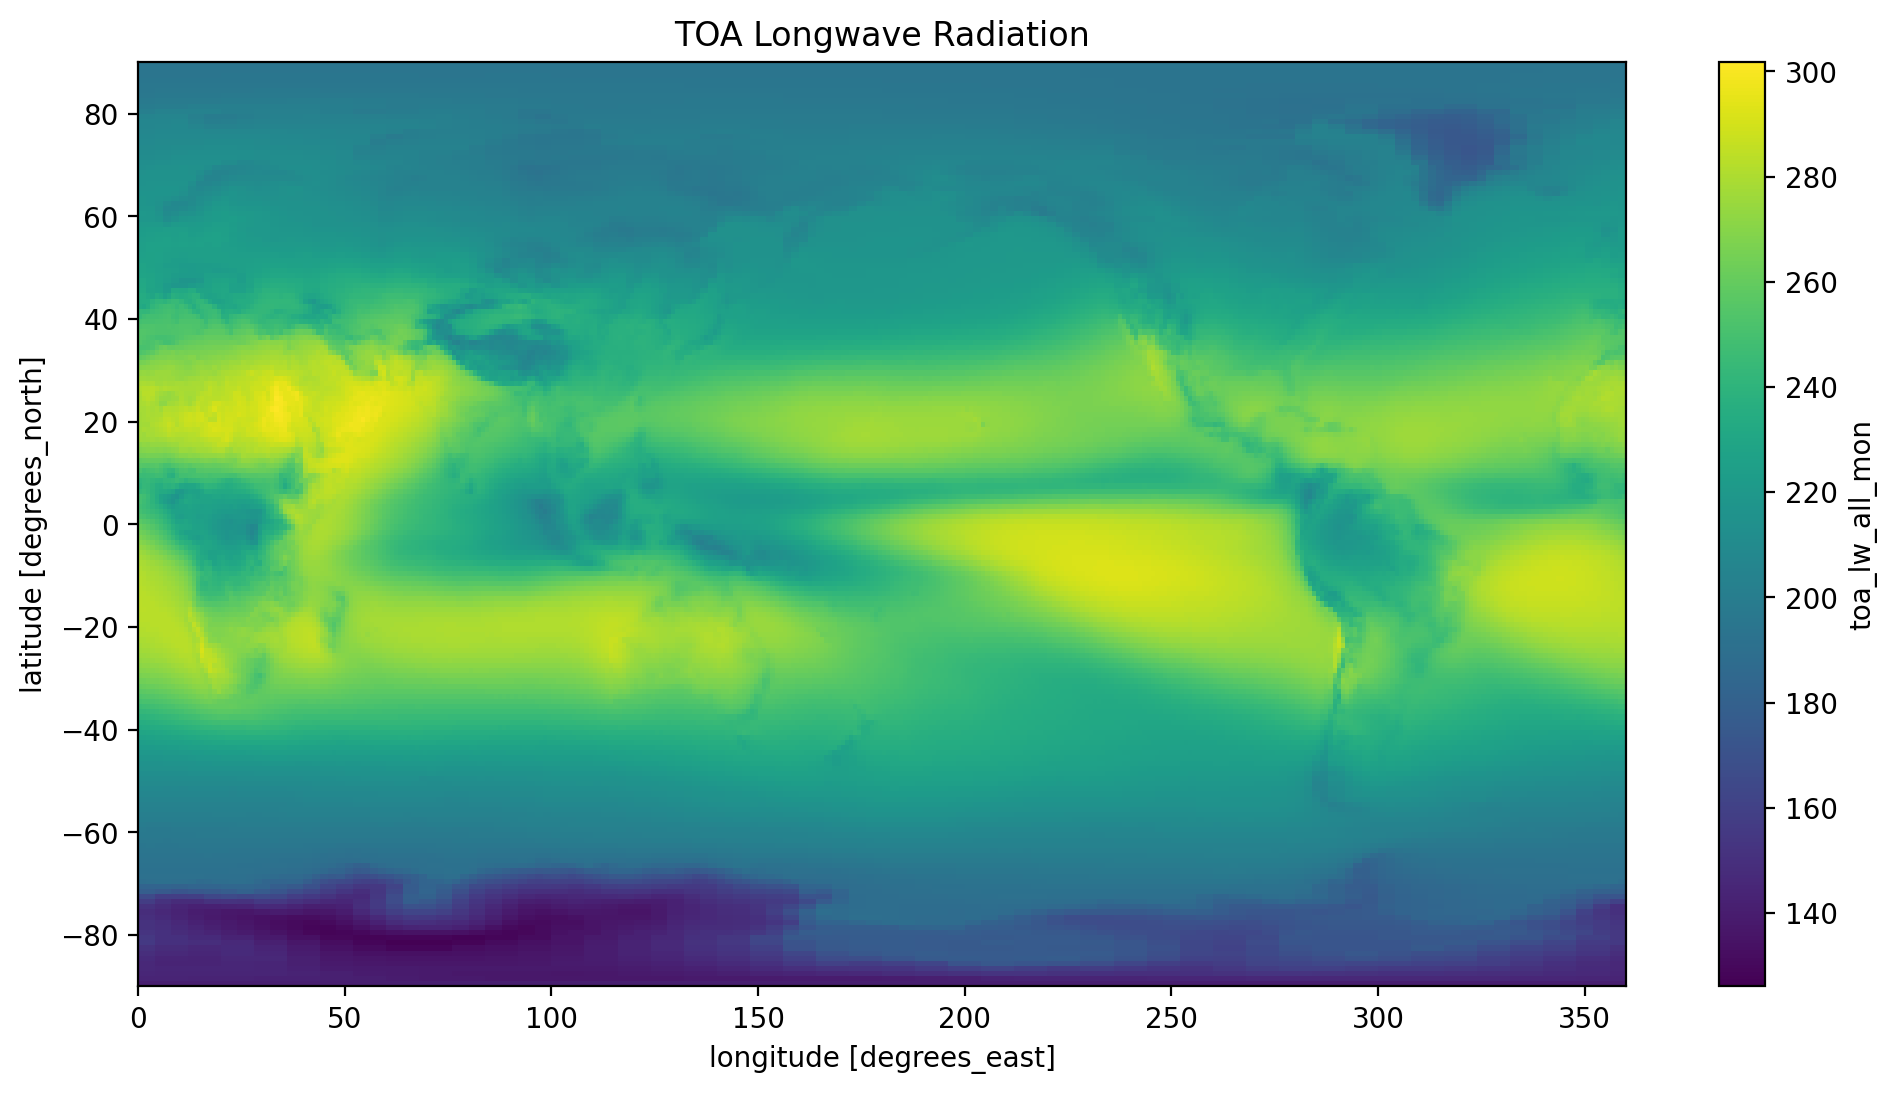

In [15]:
#plotting mean value over earth
time_mean.toa_lw_all_mon.plot(y='lat' , x='lon')
plt.title('TOA Longwave Radiation')
plt.show()

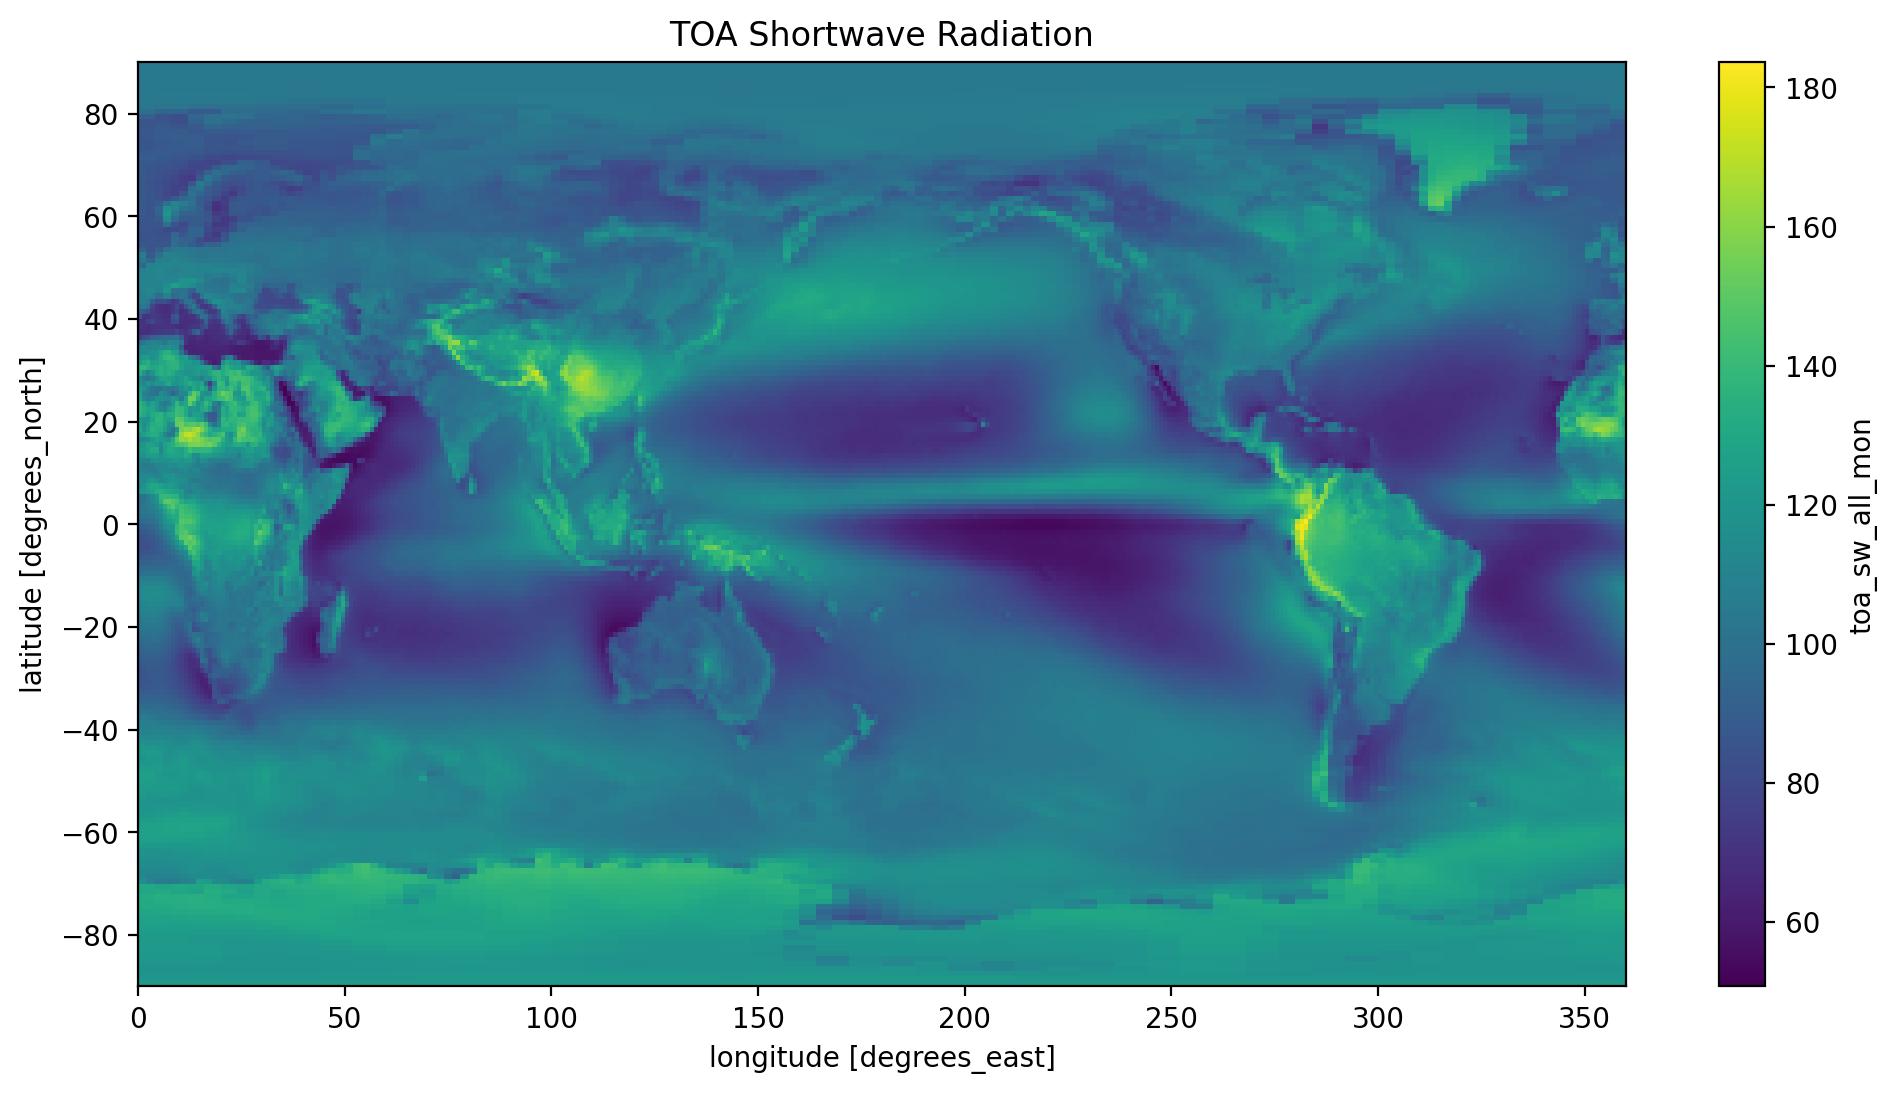

In [16]:
time_mean.toa_sw_all_mon.plot(y='lat', x='lon')
plt.title('TOA Shortwave Radiation')
plt.show()

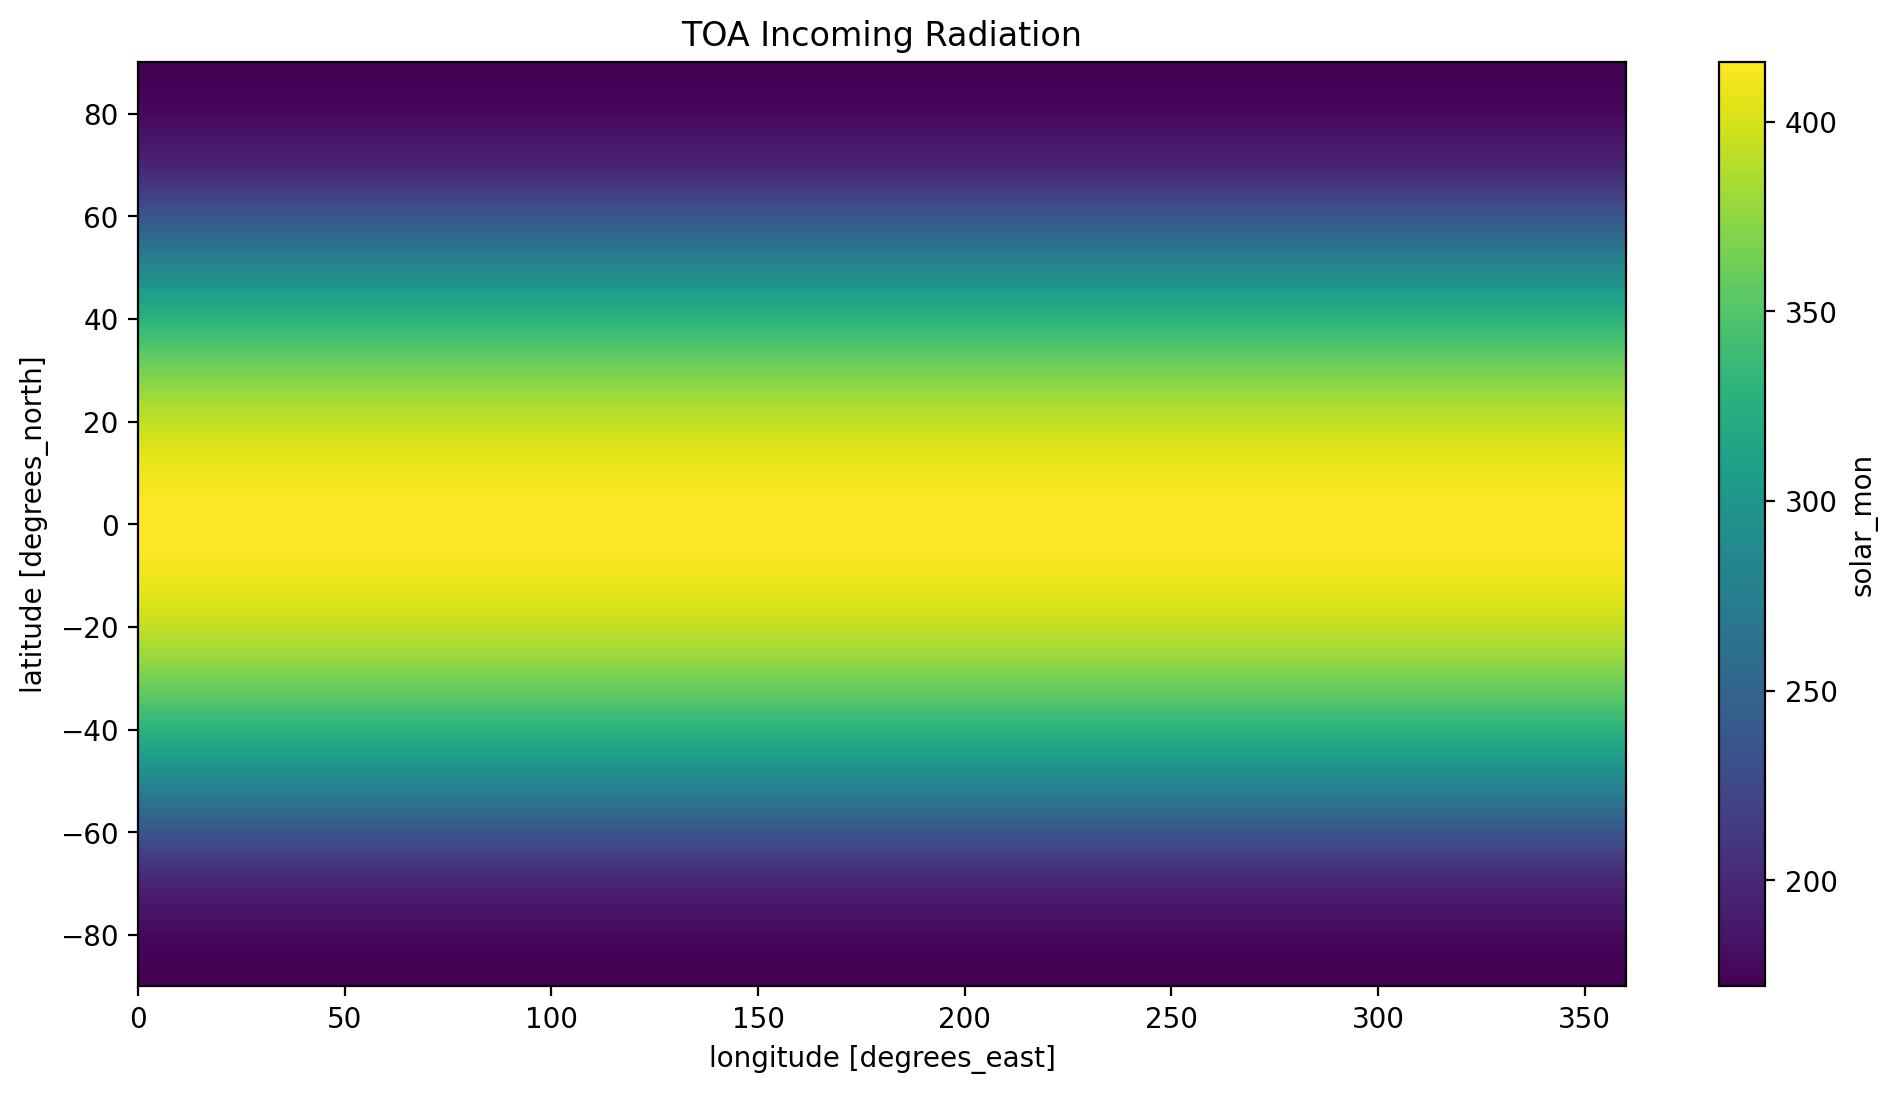

In [17]:
time_mean.solar_mon.plot(y='lat', x='lon')
plt.title('TOA Incoming Radiation')
plt.show()

Take a look at the three plots, do they make sense to you? 
Refer to the NASA at the top of this tutorial

<br>
<br>

### 2.3) Add up the three variables above and verify (visually) that they are equivalent to the TOA net flux

Refer to the NASA figure at the top of the page to understand incoming and outgoing radiation. <br>Note TOA variables measure outgoing radiation.

##### Deriving Net Flux Using Incoming and Outgoing Radiation

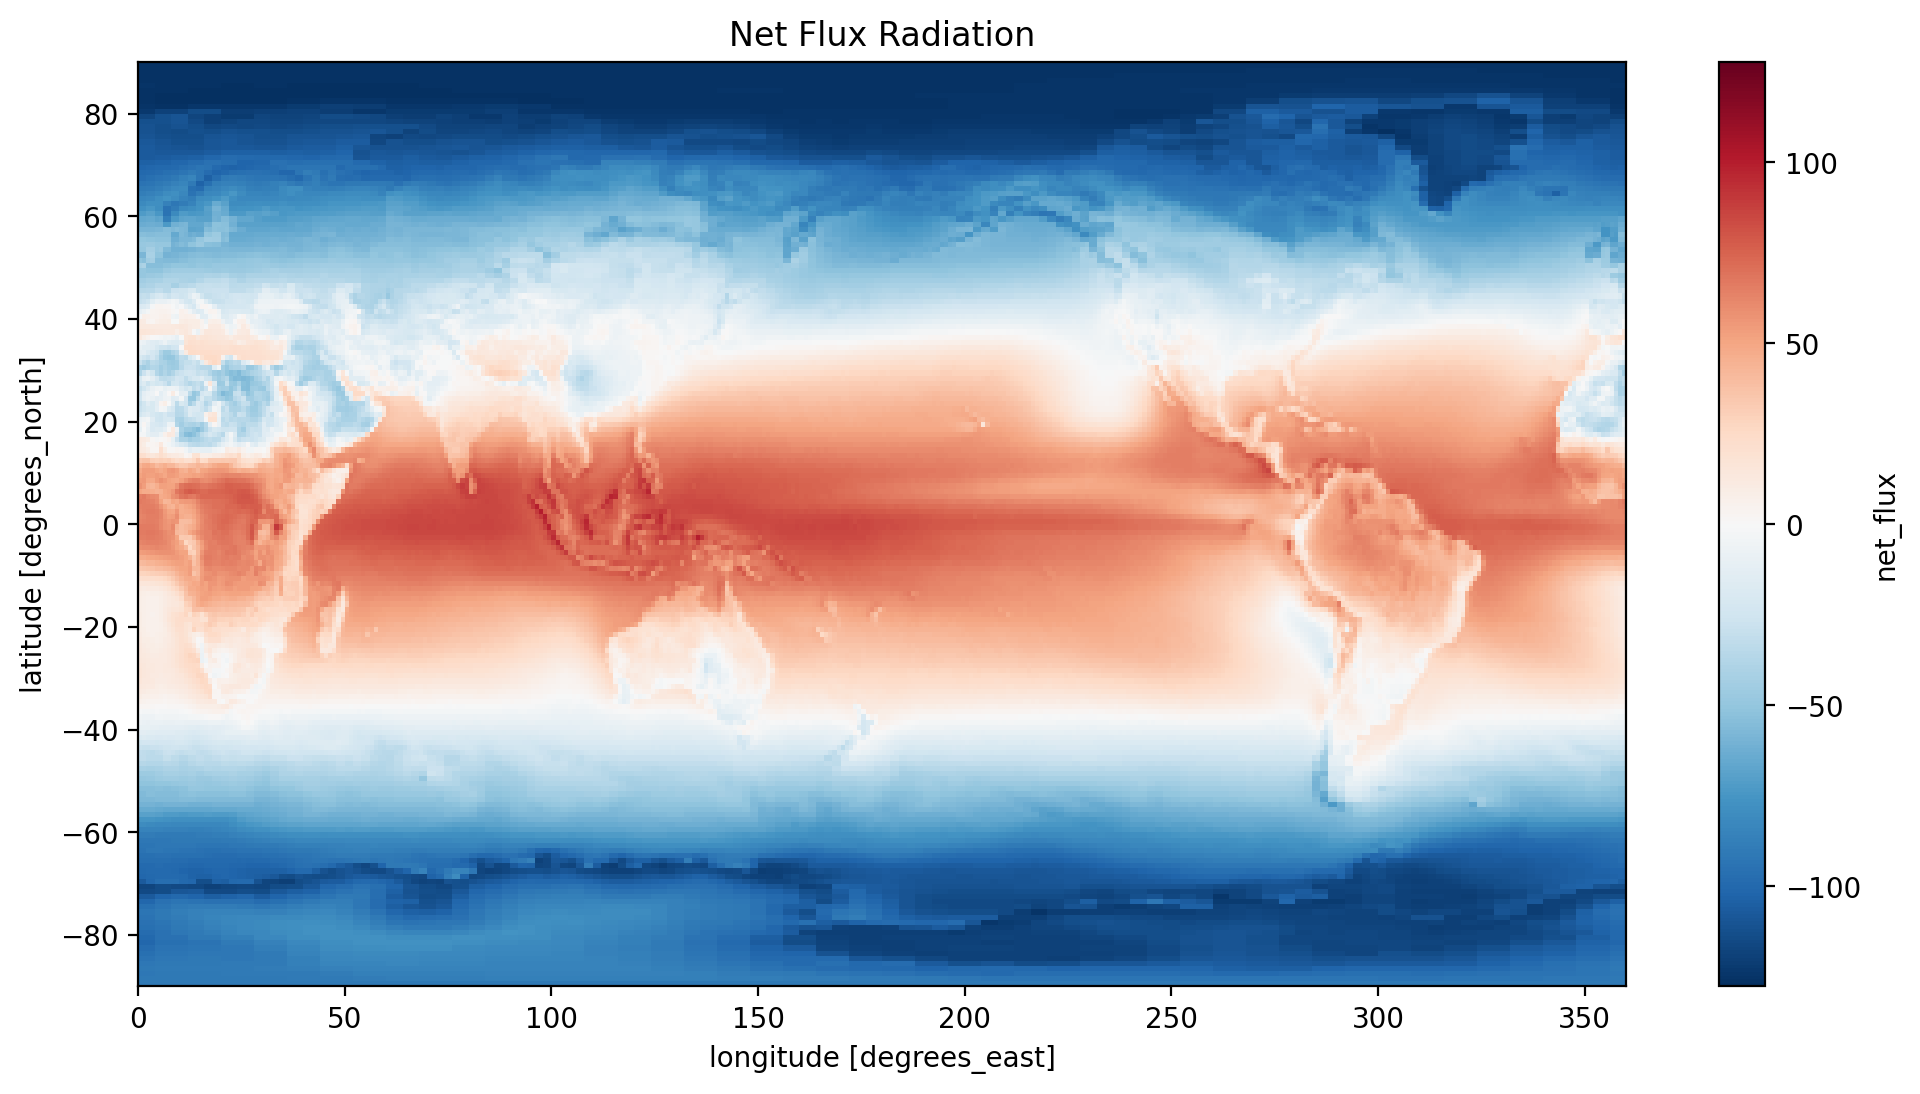

In [18]:
#calculate flux using incoming and outgoing variables
time_mean['net_flux'] = time_mean['solar_mon'] - (time_mean['toa_lw_all_mon'] + time_mean['toa_sw_all_mon'])

#plot the flux calculated
time_mean.net_flux.plot(y='lat', x='lon')
plt.title('Net Flux Radiation')
plt.show()

Note, `Xarray` supports the creation of variables in a similar manner as `Pandas`

##### Plotting Net Flux Using TOA VAriable

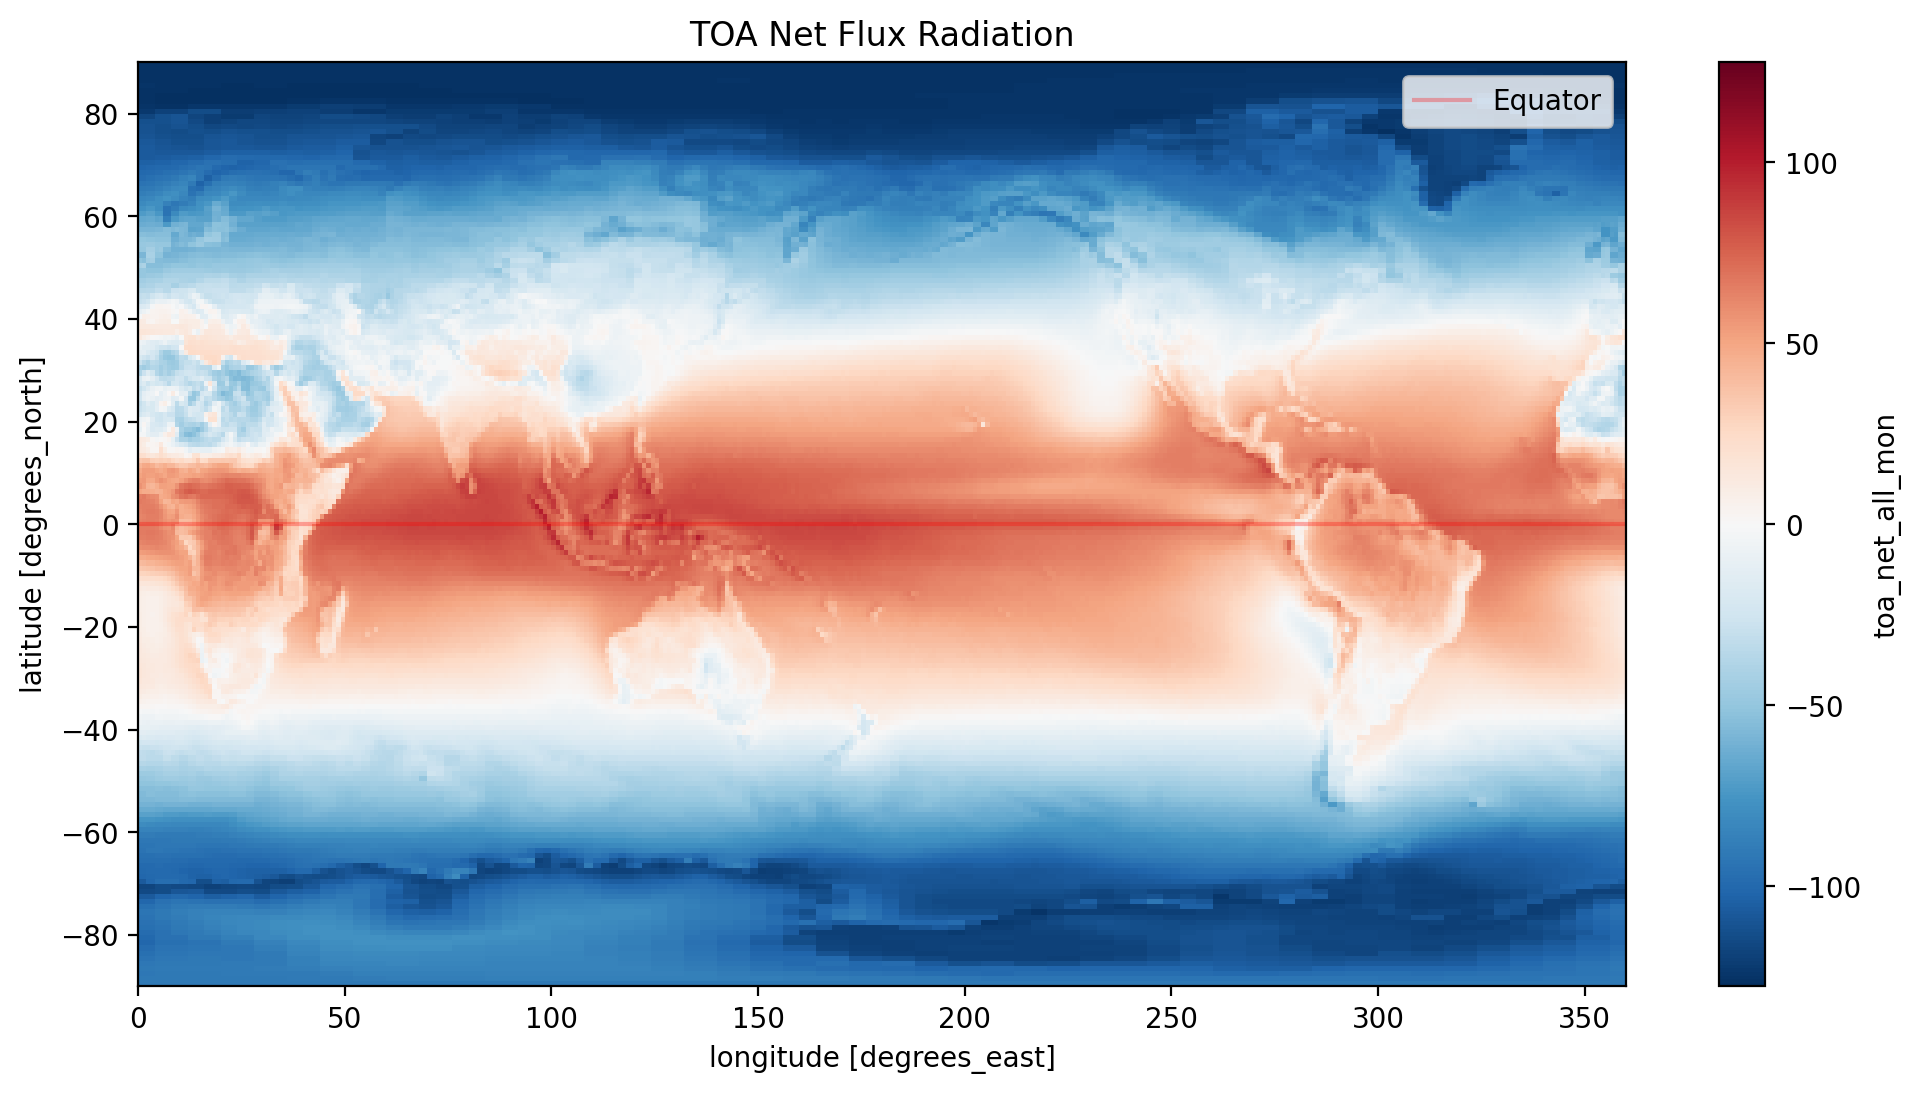

In [19]:
#plot the net flux using the original data and compare
time_mean.toa_net_all_mon.plot(y='lat', x='lon')

# add the equator and set the line thickness to 30% of 1 unit
plt.axhline(0, color='red', linestyle='solid',alpha=0.3, label='Equator')

plt.title('TOA Net Flux Radiation')
plt.legend()
plt.show()

With the integration of `Matplotlib` with `Xarray`, we expand our visualization possibilities to include additional plot elements. In this case, we've incorporated the Equator into our figure.
<br>
<br>
<br>


## 3) Mean and weighted mean

### 3.1) Calculate the global (unweighted) mean of TOA net radiation

Since the Earth is approximately in radiative balance, the net TOA radiation should be zero. But taking the naive mean from this dataset, you should find a number far from zero. Why?

In [20]:
#basic mean calculation
data['toa_net_all_mon'].mean()

<xarray.DataArray 'toa_net_all_mon' ()>
array(-28.729034, dtype=float32)

The answer is that each "pixel" or "grid point" of this dataset does not represent an equal area of Earth's surface. So naively taking the mean, i.e. giving equal weight to each point, gives the wrong answer.

On a lat / lon grid, the relative area of each grid point is proportional to $\cos(\lambda)$. ($\lambda$ is latitude)

### 3.2) Create a `weight` array proportional to $\cos(\lambda)$

We will need to convert all `lat` values to radians then supply these values to the `np.cos()` function. 


In [21]:
#convert lat to radians then use cos function
weights = np.cos(np.deg2rad(data.lat))

#name array weights
weights.name = "weights"
weights

<xarray.DataArray 'weights' (lat: 180)>
array([0.00872656, 0.02617699, 0.04361945, 0.06104851, 0.07845908,
       0.09584576, 0.11320324, 0.13052624, 0.14780948, 0.16504757,
       0.18223551, 0.19936794, 0.21643965, 0.23344542, 0.25037998,
       0.26723838, 0.28401536, 0.30070582, 0.3173047 , 0.33380693,
       0.35020736, 0.3665012 , 0.38268346, 0.3987491 , 0.4146933 ,
       0.43051115, 0.44619778, 0.4617486 , 0.47715878, 0.49242356,
       0.5075384 , 0.5224986 , 0.5372996 , 0.551937  , 0.56640625,
       0.58070296, 0.59482276, 0.6087614 , 0.62251467, 0.6360782 ,
       0.64944804, 0.66262007, 0.67559016, 0.68835455, 0.70090926,
       0.71325046, 0.72537434, 0.7372773 , 0.7489557 , 0.76040596,
       0.77162457, 0.78260815, 0.7933533 , 0.8038569 , 0.8141155 ,
       0.8241262 , 0.83388585, 0.8433914 , 0.85264015, 0.8616291 ,
       0.87035567, 0.87881714, 0.8870108 , 0.89493436, 0.90258527,
       0.9099613 , 0.9170601 , 0.9238795 , 0.9304176 , 0.9366722 ,
       0.9426415 , 0.94832367, 0.95371693, 0.95881975, 0.96363044,
       0.96814764, 0.9723699 , 0.976296  , 0.9799247 , 0.9832549 ,
       0.9862856 , 0.9890159 , 0.9914449 , 0.9935719 , 0.9953962 ,
       0.9969173 , 0.9981348 , 0.99904823, 0.99965733, 0.9999619 ,
       0.9999619 , 0.99965733, 0.99904823, 0.9981348 , 0.9969173 ,
       0.9953962 , 0.9935719 , 0.9914449 , 0.9890159 , 0.9862856 ,
       0.9832549 , 0.9799247 , 0.976296  , 0.9723699 , 0.96814764,
       0.96363044, 0.95881975, 0.95371693, 0.94832367, 0.9426415 ,
       0.9366722 , 0.9304176 , 0.9238795 , 0.9170601 , 0.9099613 ,
       0.90258527, 0.89493436, 0.8870108 , 0.87881714, 0.87035567,
       0.8616291 , 0.85264015, 0.8433914 , 0.83388585, 0.8241262 ,
       0.8141155 , 0.8038569 , 0.7933533 , 0.78260815, 0.77162457,
       0.76040596, 0.7489557 , 0.7372773 , 0.72537434, 0.71325046,
       0.70090926, 0.68835455, 0.67559016, 0.66262007, 0.64944804,
       0.6360782 , 0.62251467, 0.6087614 , 0.59482276, 0.58070296,
       0.56640625, 0.551937  , 0.5372996 , 0.5224986 , 0.5075384 ,
       0.49242356, 0.47715878, 0.4617486 , 0.44619778, 0.43051115,
       0.4146933 , 0.3987491 , 0.38268346, 0.3665012 , 0.35020736,
       0.33380693, 0.3173047 , 0.30070582, 0.28401536, 0.26723838,
       0.25037998, 0.23344542, 0.21643965, 0.19936794, 0.18223551,
       0.16504757, 0.14780948, 0.13052624, 0.11320324, 0.09584576,
       0.07845908, 0.06104851, 0.04361945, 0.02617699, 0.00872656],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:      latitude
    standard_name:  latitude
    units:          degrees_north
    valid_range:    [-90.  90.]

### 3.3) Redo the global mean TOA net radiation calculation with this weight factor

Use xarray's [weighted array reductions](http://xarray.pydata.org/en/stable/user-guide/computation.html#weighted-array-reductions) to compute the weighted mean.

In [23]:
#created a weighted dataset

data_weighted = data.weighted(weights)

#selecting variables from weighted dataset objects
data_weighted.mean().toa_net_all_mon

<xarray.DataArray 'toa_net_all_mon' ()>
array(0.8780852, dtype=float32)

Now we get a value closer to 0

The `weighted()` function yields a `DatasetWeighted` [object](https://docs.xarray.dev/en/stable/generated/xarray.core.weighted.DatasetWeighted.html). While extracting a single variable is feasible, it differs from the typical approach used with a standard xarray dataset. Please review [Xarray documentation](https://docs.xarray.dev/en/latest/examples/area_weighted_temperature.html) for more information.

<br>
<br>

### 3.4) Now that you have a `weight` factor, verify that the TOA incoming solar, outgoing longwave, and outgoing shortwave approximately match up with infographic shown in the first cell of the tutorial


In [24]:
#multi variable selection of weighted dataset object
data_weighted.mean()[['toa_lw_all_mon','toa_sw_all_mon','solar_mon']]

<xarray.Dataset>
Dimensions:         ()
Data variables:
    toa_lw_all_mon  float32 240.3
    toa_sw_all_mon  float32 99.14
    solar_mon       float32 340.3


- `solar_mon` is 340 in the graphic and 340.3 from our calculation
- `toa_sw_all_mon` is the sum of reflected by surface and clouds, 99 which is close to our calculation
- `toa_lw_all_mon` is 239.9 in the graphic which again is consistant with our result of 240



<br>
<br>
<br>

## 4) Meridional Heat Transport Calculation
#### Concepts for computation

We can go beyond a weight factor and actually calculate the area of each pixel of the dataset. Because latitude and longitude correspond to spherical coordinates for Earth’s surface, each 1.0x1.0 degree grid cell actually has a different surface area as you move away from the equator! This is because latitudinal length is fixed ($  dLat = R d\varphi $), but longitudinal length varies with latitude ($ d Lon = R d\lambda \cos(\varphi) $)

So the area element for lat-lon coordinates is

$$ dA = R^2 \cos(\lambda) d\lambda d \varphi $$

where $\varphi$ is latitude, $d\varphi$ is the spacing of the points in latitude, $d\lambda$ is the spacing of the points in longitude, and $R = 6,371$ km is Earth’s radius. (In this formula, $\varphi$ and $\lambda$ are measured in radians) 

For more information, check out the [xarray in 45 min by OceanHackWeek](https://oceanhackweek.org/ohw22/tutorials/00-Mon/xarray-in-45-min.html).



### 4.1) calculate the pixel area using this formula and create a 2D (lon, lat) DataArray for it

We will need to specify the radius, $d\varphi$ and $d\lambda$ (from the dataset)

In [25]:
# Earth's average radius in km
R = 6371.0

# Coordinate spacing between each lat/lon is 1.0 degrees in the dataset
d_lambda = np.deg2rad(1.0)
d_phi = np.deg2rad(1.0)

#calculation
r_squared = R**2
dA = r_squared * np.cos(np.deg2rad(data.lat)) * d_lambda * d_phi



Now, to calculate the surface area

In [26]:
#broadcasting array
ones_array = xr.ones_like(data)
#multiply ones array by dA
pixel_area_da = ones_array * dA
#total_area
total_pixel_area = pixel_area_da.sum(dim=['lat', 'lon'])


#earth's surface area
earth_surface = 4 * np.pi * r_squared


The `ones_like()` function creates an array with the same shape and data type as the input array `data`, but with all elements set to 1. 

Let's compare our array calculation to the surface calculation using the surface area of a sphere formula.

In [27]:
#verify the calculation was correct

print(f" the pixel area is calculated to be {total_pixel_area.toa_sw_all_mon[0].values} and the surface area of the earth is {earth_surface}.")


 the pixel area is calculated to be 510070944.0 and the surface area of the earth is 510064471.90978825.


<br>
<br>


### 4.2) Calculate and plot the total amount of net radiation in each 1-degree latitude band
Multiplying the pixel area (m$^2$) from above with the radiative flux (W m$^{-2}$) gives you the total amount of radiation absorbed in each pixel in W.

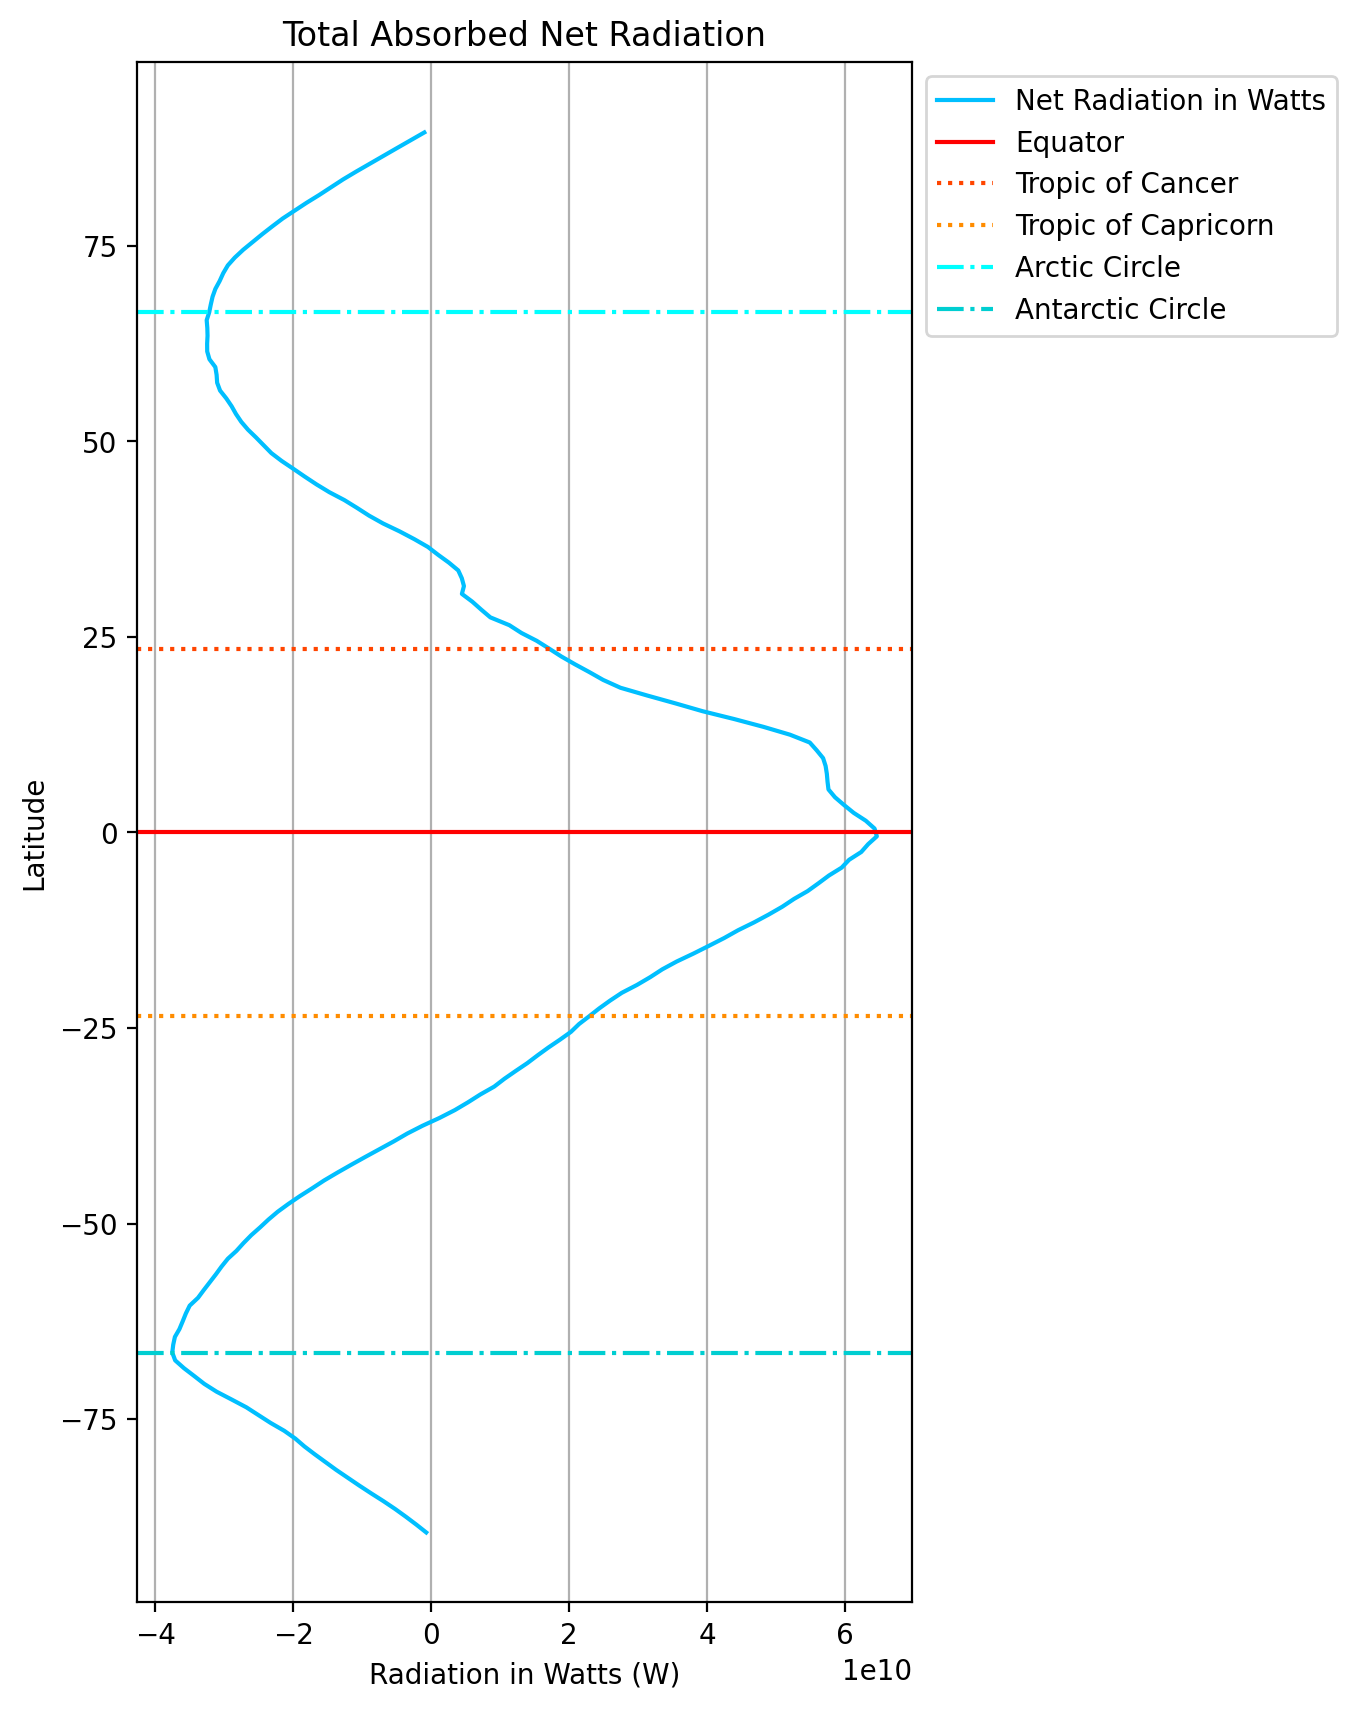

In [28]:
#create dataset of area * net
net_by_area = dA * data.toa_net_all_mon


#create figure
plt.figure(figsize=(5,10))

#plot data - summing along lon and time leaving lat uncompressed
net_by_area.sum(dim=['lon','time']).plot(y='lat', color='deepskyblue',label='Net Radiation in Watts')

#major lines of latitude
plt.axhline(0, color='red', linestyle='solid', label='Equator')
plt.axhline(23.5, color='orangered', linestyle='dotted', label='Tropic of Cancer')
plt.axhline(-23.5, color='darkorange', linestyle='dotted', label='Tropic of Capricorn')
plt.axhline(66.5, color='cyan', linestyle='dashdot', label='Arctic Circle')
plt.axhline(-66.5, color='darkturquoise', linestyle='dashdot', label='Antarctic Circle')

#make legend and place outside of plot
plt.legend(loc='upper left', bbox_to_anchor=(1,1))

#create titles
plt.title('Total Absorbed Net Radiation')
plt.ylabel('Latitude')
plt.xlabel('Radiation in Watts (W)')

plt.grid(which='major', axis='x')

plt.show()


Carefully review the code to generate this plot then make the same plot for incoming radation and total outgoing (short+long) 
<br>
<br>

### 4.3) Plot the cumulative sum of the total amount of net radiation as a function of latitude

check out xarray's [cumsum](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.cumsum.html) function.

This curve tells you how much energy must be transported meridionally by the ocean and atmosphere in order to account for the radiative imbalance at the top of the atmosphere. Take a look at [Chapter 2.1.5.2 of Introduction to Climate Dynamics and Climate Modelling](https://www.climate.be/textbook/chapter2_node7_2.xml) for a better understanding of this concept.

A curve that looks something like this: https://journals.ametsoc.org/view/journals/clim/14/16/full-i1520-0442-14-16-3433-f07.gif (Figure from Trenberth & Caron, 2001)

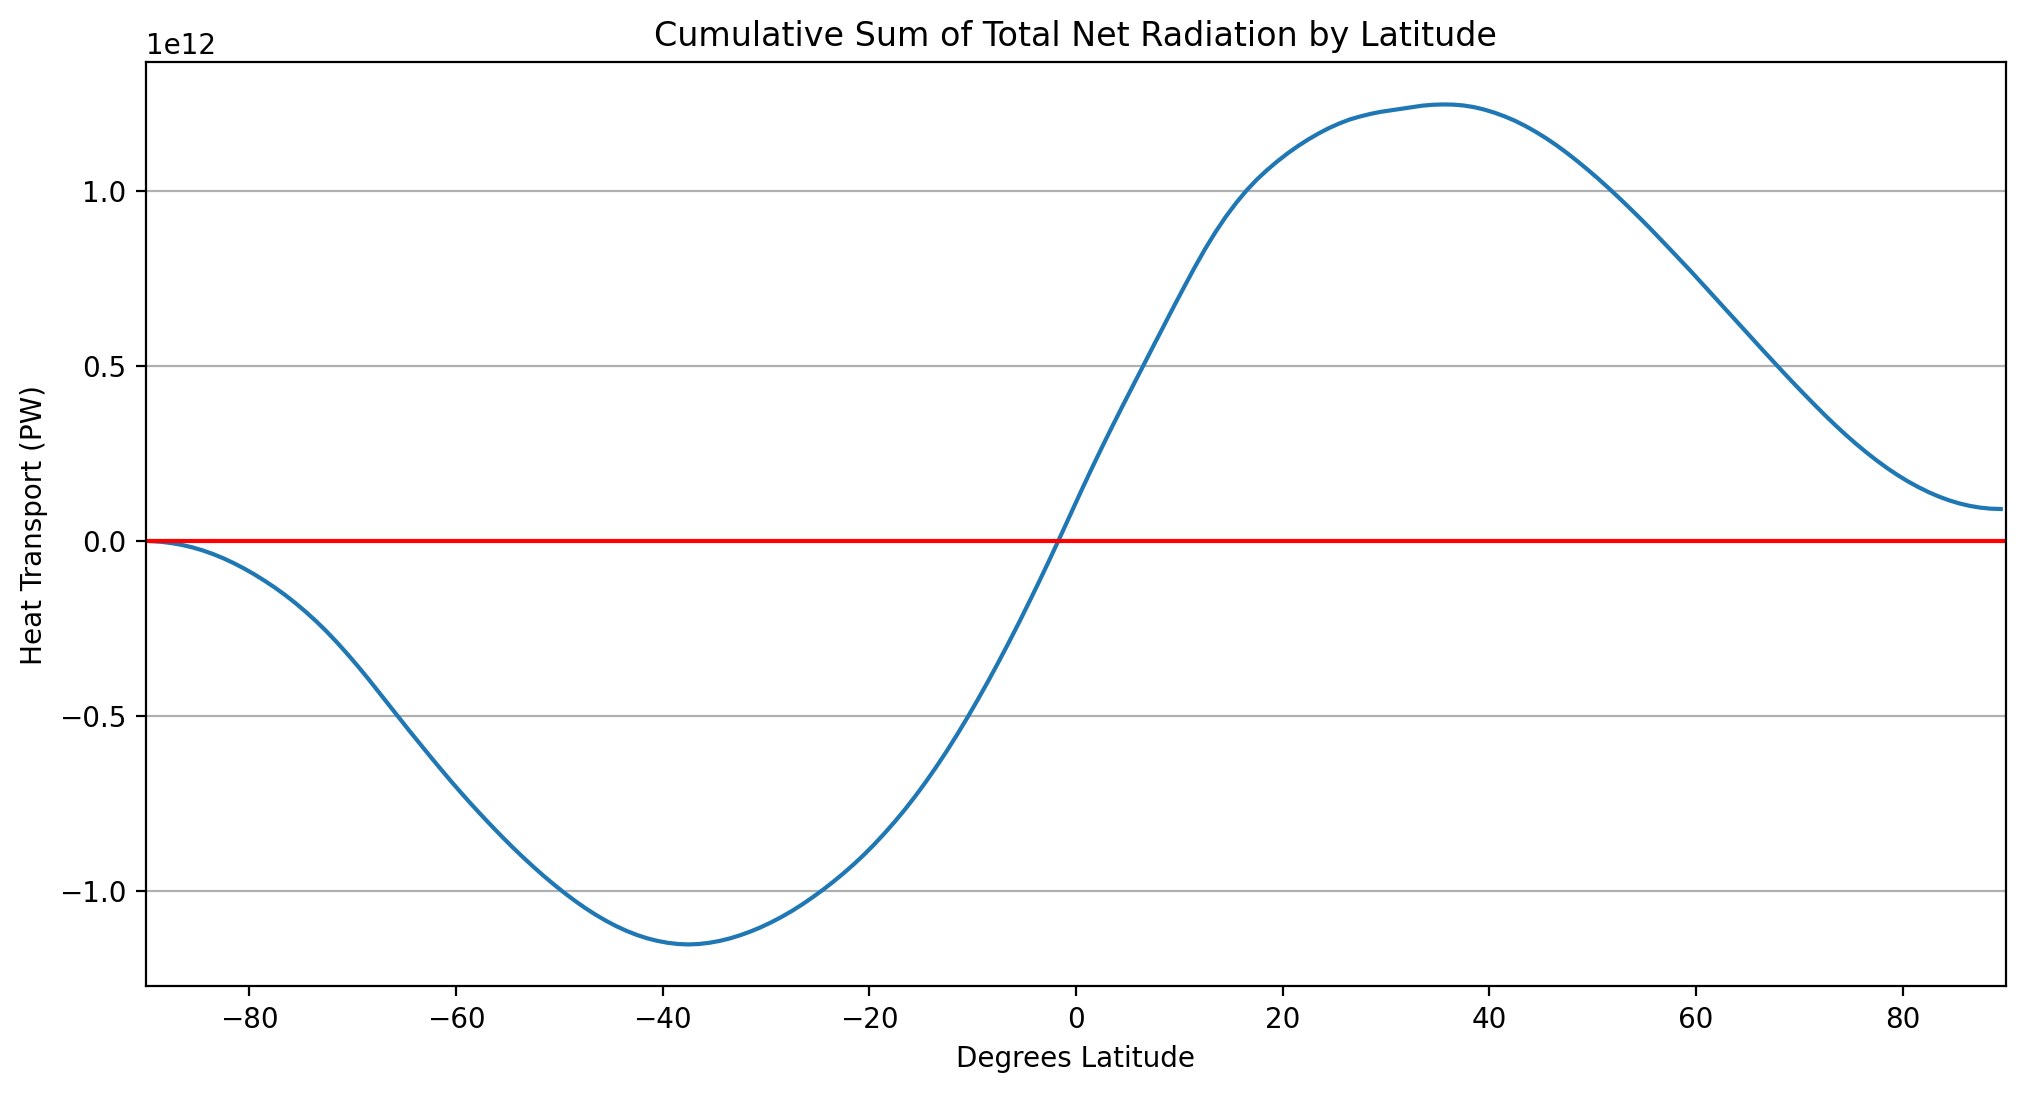

In [29]:
# create a variable to hold the total
total = net_by_area.sum(dim=['lon','time'])

#take cumsum of total
cumsum_total = total.cumsum()

#plot cumsum
cumsum_total.plot()
#plot y=0
plt.axhline(0, color='red', linestyle='solid')

#set x limits
plt.xlim([-90,90])

#add grid
plt.grid(which='major', axis='y')

#create titles
plt.title('Cumulative Sum of Total Net Radiation by Latitude')
plt.xlabel('Degrees Latitude')
plt.ylabel('Heat Transport (PW)')

plt.show()



## 5) Selecting and Merging Data

For the next problem, use the following approximate locations of four different cities.

| city | lon | lat |
| -- | -- | -- |
| Toronto, Ontario |79 W | 42 N | 
| Bridgetown, Barbados|59 W | 13 N |
| Nome, Alaska | 165 W | 64 N | 
| Columbo, Sri Lanka | 80 E | 7 N |
| Hobart, Tasmania | 147 E | 43 S |

Remember the range of the index values for lon and lat, especially if slicing.
  - lon is $ [0, 360] $
  - lat is $ [-90, 90]$

### 5.1) Create a `Dataset` for each point from the global dataset
Each city will get its own `Dataset` with the same variables as the one we imported.

The `sel()` function allows us to specify specific coordinates on which to subset our data.

In [30]:
#selecting specific data

Nome = data.sel(lon=194.5, lat=63.5)
Colombo = data.sel(lon=79.5, lat=6.5)
Hobart = data.sel(lon=146.5, lat=-42.5)
Bridgetown = data.sel(lon=300.5, lat=12.5)
Toronto = data.sel(lon=280.5, lat=41.5)

$lon = 360 + lon$ <br> where **Westward longitudes are negative** and **Eastward longitudes are positive** float values

Nome is $lon - 360 +(-165) = 195$

In [31]:
#let's take a look at toronto

Toronto

<xarray.Dataset>
Dimensions:                      (time: 203)
Coordinates:
    lon                          float32 280.5
  * time                         (time) datetime64[ns] 2000-03-15 ... 2017-01-15
    lat                          float32 41.5
Data variables: (12/14)
    toa_sw_all_mon               (time) float32 123.5 156.5 ... 83.69 86.98
    toa_lw_all_mon               (time) float32 219.6 215.8 ... 201.6 198.7
    toa_net_all_mon              (time) float32 -26.84 27.34 ... -137.2 -117.8
    toa_sw_clr_mon               (time) float32 52.66 64.84 ... 34.75 37.99
    toa_lw_clr_mon               (time) float32 249.4 258.5 ... 227.0 232.5
    toa_net_clr_mon              (time) float32 14.14 76.28 ... -113.6 -102.6
    ...                           ...
    toa_cre_net_mon              (time) float32 -40.98 -48.94 ... -23.57 -15.14
    solar_mon                    (time) float32 316.2 399.6 ... 148.1 167.9
    cldarea_total_daynight_mon   (time) float32 60.34 72.11 69.97 ... 88.08 89.1
    cldpress_total_daynight_mon  (time) float32 597.5 536.2 ... 607.7 572.0
    cldtemp_total_daynight_mon   (time) float32 254.1 250.8 ... 251.0 249.2
    cldtau_total_day_mon         (time) float32 10.76 13.29 ... 18.24 12.37
Attributes:
    title:             CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Mo...
    institution:       NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:       CF-1.4
    comment:           Data is from East to West and South to North.
    Version:           Edition 4.0; Release Date March 7, 2017
    Fill_Value:        Fill Value is -999.0
    DOI:               10.5067/TERRA+AQUA/CERES/EBAF-TOA_L3B.004.0
    Production_Files:  List of files used in creating the present Master netC...

Observe the `Toronto` variables stores a dataset object containing all the variables and metadata of the original dataset

### 5.2) Merge these datasets into a new dataset with the new dimension `city`

We first need to create a new coordinate for each city.

In [32]:

Toronto = Toronto.assign_coords({'City': 'Toronto'})
Nome = Nome.assign_coords({'City': 'Nome'})
Colombo = Colombo.assign_coords({'City': 'Colombo'})
Bridgetown = Bridgetown.assign_coords({'City': 'Bridgetown'})
Hobart = Hobart.assign_coords({'City': 'Hobart'})

Now we can utilise the `concat()` function to merge the datasets on the new `City` dimension.

In [33]:
#concatenate the cities on the City dimension
Cities = xr.concat([Toronto, Hobart, Bridgetown, Colombo, Nome],dim='City')

In [34]:
Cities

<xarray.Dataset>
Dimensions:                      (City: 5, time: 203)
Coordinates:
    lon                          (City) float32 280.5 146.5 300.5 79.5 194.5
  * time                         (time) datetime64[ns] 2000-03-15 ... 2017-01-15
    lat                          (City) float32 41.5 -42.5 12.5 6.5 63.5
  * City                         (City) <U10 'Toronto' 'Hobart' ... 'Nome'
Data variables: (12/14)
    toa_sw_all_mon               (City, time) float32 123.5 156.5 ... 13.39
    toa_lw_all_mon               (City, time) float32 219.6 215.8 ... 198.8
    toa_net_all_mon              (City, time) float32 -26.84 27.34 ... -189.5
    toa_sw_clr_mon               (City, time) float32 52.66 64.84 ... 4.86 10.71
    toa_lw_clr_mon               (City, time) float32 249.4 258.5 ... 215.7
    toa_net_clr_mon              (City, time) float32 14.14 76.28 ... -203.8
    ...                           ...
    toa_cre_net_mon              (City, time) float32 -40.98 -48.94 ... 14.27
    solar_mon                    (City, time) float32 316.2 399.6 ... 22.65
    cldarea_total_daynight_mon   (City, time) float32 60.34 72.11 ... 71.77
    cldpress_total_daynight_mon  (City, time) float32 597.5 536.2 ... 674.9
    cldtemp_total_daynight_mon   (City, time) float32 254.1 250.8 ... 245.1
    cldtau_total_day_mon         (City, time) float32 10.76 13.29 ... 2.68 3.298
Attributes:
    title:             CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Mo...
    institution:       NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:       CF-1.4
    comment:           Data is from East to West and South to North.
    Version:           Edition 4.0; Release Date March 7, 2017
    Fill_Value:        Fill Value is -999.0
    DOI:               10.5067/TERRA+AQUA/CERES/EBAF-TOA_L3B.004.0
    Production_Files:  List of files used in creating the present Master netC...

### 5.3) Plot the incoming solar and net radiation at each city


In [35]:
#index of the cities
index_list = list(Cities['City'].indexes['City'])

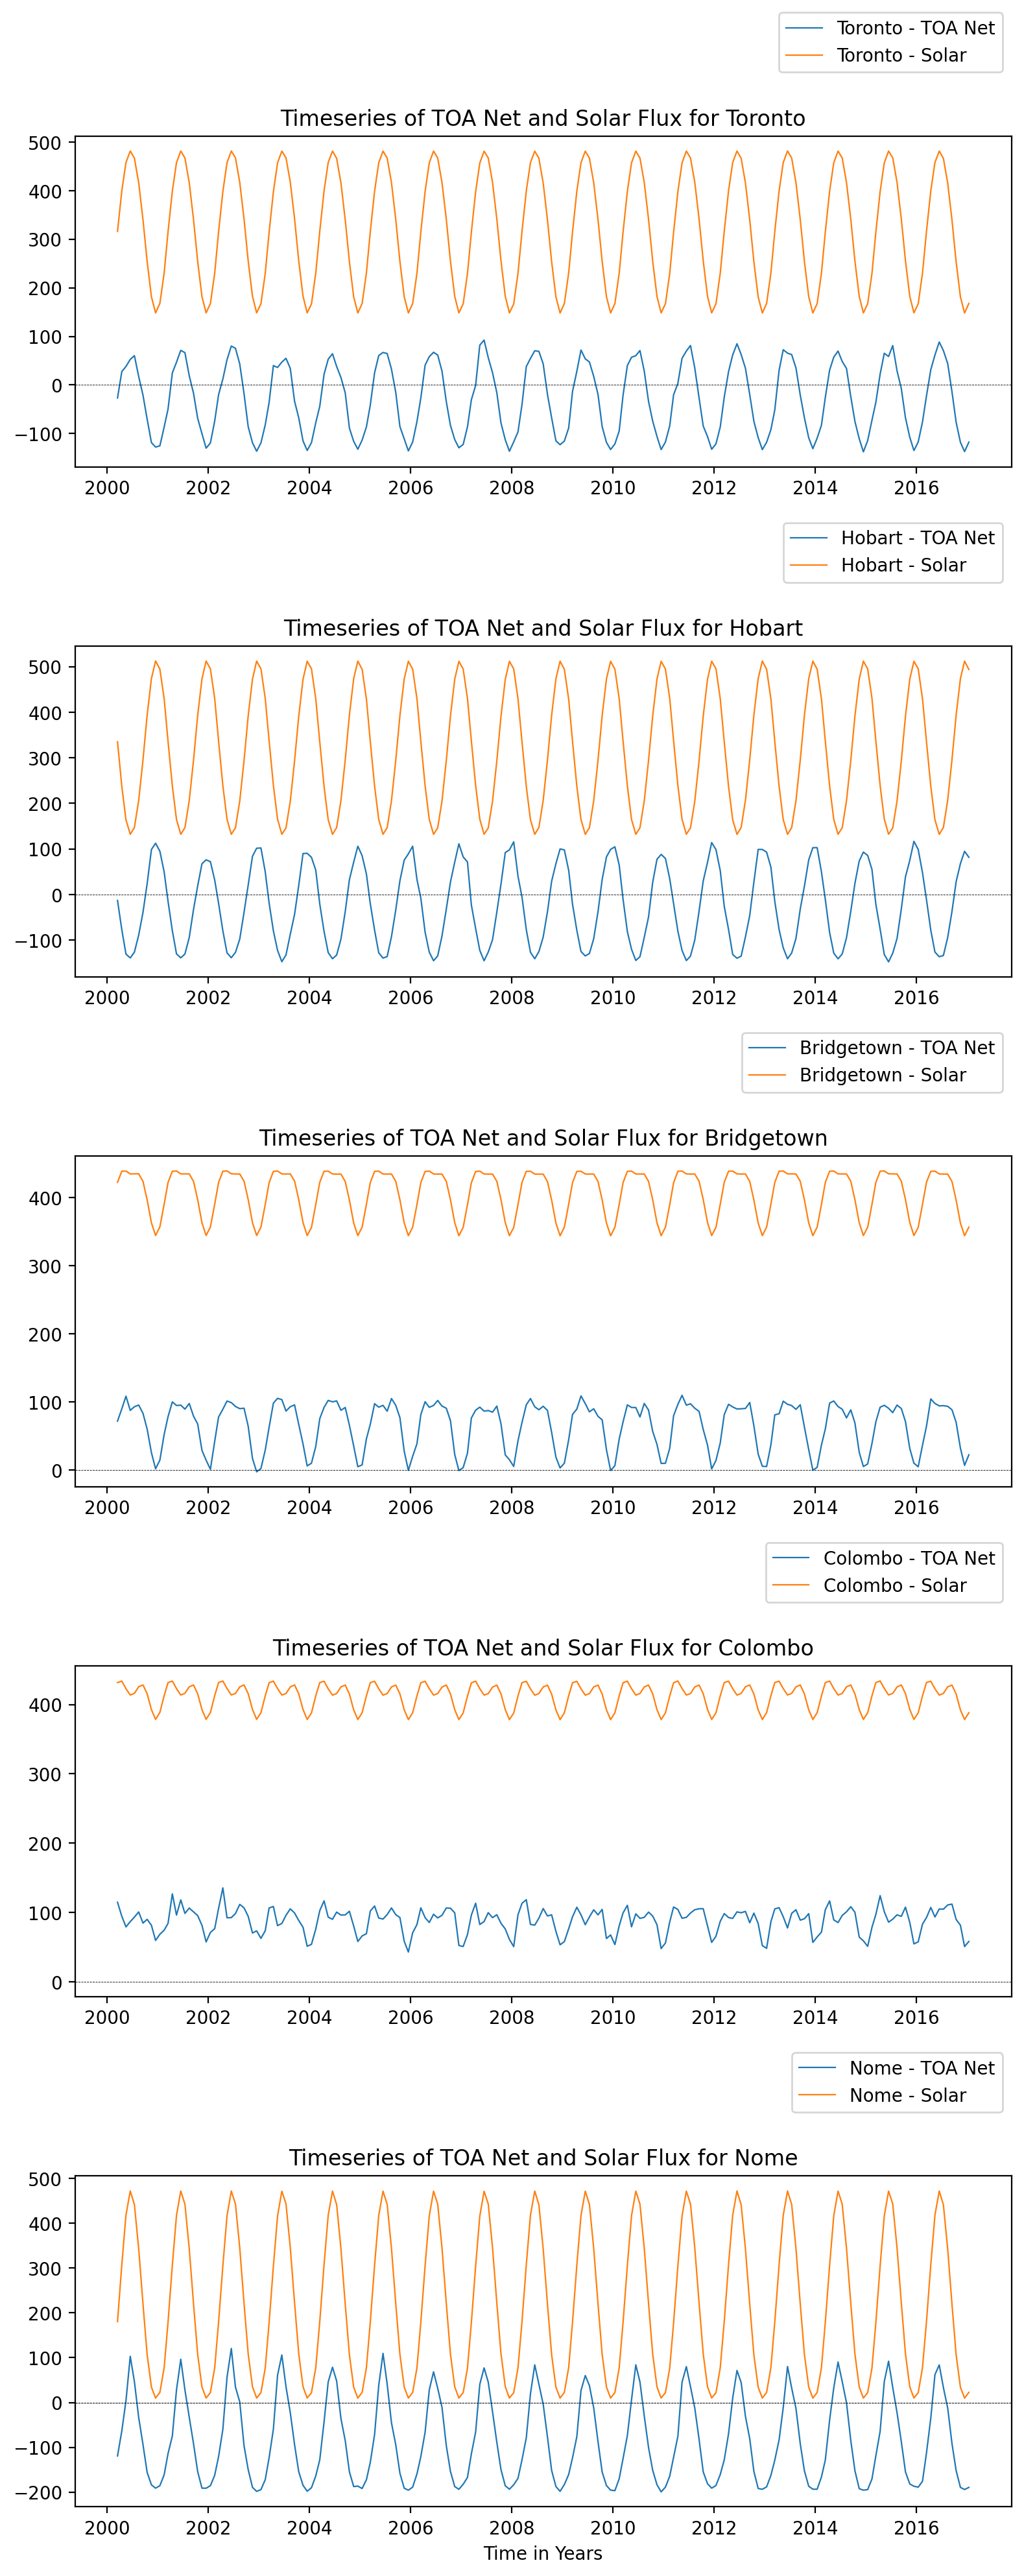

In [45]:
# Create subplots for each city

rows = len(index_list)
fig, axes = plt.subplots(rows, 1, figsize=(8, rows*4), sharex=False)


#iterate through the index list and select the city for plotting
for i, city in enumerate(index_list):
    data_net = Cities.toa_net_all_mon.sel(City=city)
    data_in = Cities.solar_mon.sel(City=city)

    # Plot each city's data on a separate subplot
    axes[i].plot(Cities.time, data_net, linewidth=0.8, label=f'{city} - TOA Net')
    axes[i].plot(Cities.time, data_in, linewidth=0.8, label=f'{city} - Solar')
    axes[i].axhline(0, linestyle='dashed', linewidth=0.3, color='black')
    axes[i].set_title(f"Timeseries of TOA Net and Solar Flux for {city}")
    axes[i].legend(bbox_to_anchor=(1,1.4))


plt.axhline(0, linestyle ='dashed', linewidth=0.3, color='black')
plt.xlabel('Time in Years')
#plt.legend(bbox_to_anchor=(1,1.4))
plt.tight_layout()
plt.show()

Examine the identified pattern and assess its suitability within the context of the specific location.

### Final Thoughts

By now, you should have acquired a foundational understanding of data structures and manipulation in Xarray through this example. If you have additional questions, I suggest referring to the comprehensive [Xarray documentation](https://docs.xarray.dev/en/stable/index.html) for further guidance. <b/>